## Imports

In [51]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from skopt import BayesSearchCV


from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OneHotEncoder,CountFrequencyEncoder,OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer,LabelEncoder,label_binarize

from sklearn.metrics import (accuracy_score, roc_auc_score,explained_variance_score,mean_squared_error,r2_score,average_precision_score, classification_report, roc_curve, auc, confusion_matrix, 
                     precision_recall_fscore_support,make_scorer, f1_score,precision_score,recall_score, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall,plot_roc_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df = pd.read_csv('data.csv')


## Pipelines
Se crean variables para unificar y entrenar el modelo a ver si es cancer o no.

In [53]:
df["is_cancer"] = df["diagnostic"].apply(lambda x: 1 if x in ["BCC","MEL","SCC"] else 0)

In [54]:
df.columns

Index(['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father',
       'background_mother', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'region', 'diameter_1',
       'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed',
       'elevation', 'img_id', 'biopsed', 'is_cancer'],
      dtype='object')

In [55]:
# la persona estuvo aca antes? Tuvo en esta parte del cuerpo antes? Que tuvo antes? -> me parece que va a overfitear con eso


x = df.drop(columns=["is_cancer", "diagnostic"]) 
y1 = df["is_cancer"]
y2 = df["diagnostic"]

class HadBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, y):
        self.patient_counts = x["patient_id"].value_counts()
        #x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts[x] -1  )
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x["patient_id"].value_counts()
        if new_counts.equals( self.patient_counts):
            new_counts = {}

        x["had_here_before"] = x["patient_id"].apply(lambda x: self.patient_counts.get(x,0)+ new_counts.get(x,0) -1   )
        return x
    
class HadThisPartBeforeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x:pd.DataFrame, _):
        self.patient_region_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        return self
    def transform(self, x:pd.DataFrame):
        new_counts = x.groupby(["patient_id", "region"]).size().unstack(fill_value=0).T.to_dict('dict')
        if new_counts == self.patient_region_counts:
            new_counts = {}
        x["had_this_part_before"] = x.apply(lambda row: 1 if  new_counts.get(row["patient_id"],{}).get(row["region"],0) + self.patient_region_counts.get(row["patient_id"],{}).get(row["region"],0)>=2 else 0, axis=1)
        return x
    


class NormalDistributionImputer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we will store the mean and std of the variables for prediction time
        self.param_dict_ = {}
        for var in self.variables:
            self.param_dict_[var] = {'mean': X[var].mean(), 'std': X[var].std()}
        return self

    def transform(self, X):
        #TODO: Agregar seed para random
        X = X.copy()
        for feature in self.variables:
            mu, std = self.param_dict_[feature]['mean'], self.param_dict_[feature]['std']
            X[feature] = X[feature].apply(lambda x: np.random.normal(loc=mu, scale=std) if pd.isnull(x) else x)
        return X

class ClassifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classifier_class, new_column_name,
                  target_column=False, eta=0.3,max_depth=6 ,
                   scale_pos_weight=1,min_child_weight=1,gamma =0,
                   subsample=1,colsample_bytree=1,n_estimators=100):
        self.classifier_class = classifier_class
        self.eta = eta
        self.max_depth = max_depth
        self.scale_pos_weight = scale_pos_weight
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.n_estimators = n_estimators
        self.gamma = gamma
        self.classifier_kwargs = {"eta":eta, "max_depth":max_depth,"scale_pos_weight":scale_pos_weight}
        self.new_column_name = new_column_name
        self.target_column = target_column

        self.label_encoder = LabelEncoder()

    def fit(self, x, y):
        self.classifier = self.classifier_class(eta=self.eta, max_depth=self.max_depth,
        scale_pos_weight=self.scale_pos_weight,min_child_weight = self.min_child_weight,
        gamma = self.gamma,subsample=self.subsample,colsample_bytree=self.colsample_bytree,n_estimators=self.n_estimators )

        if self.target_column:
            y = y.apply(lambda x: 1 if x in ["BCC","MEL","SCC"] else 0)
        else:
            y = self.label_encoder.fit_transform(y)

        # Ensure x and y have the same length
        if len(x) != len(y):
            raise ValueError(f'Length of x ({len(x)}) does not match length of y ({len(y)})')

        self.classifier.fit(x, y)
        return self

    def transform(self, x):
        if not hasattr(self, 'classifier'):
            raise RuntimeError('You must call fit before calling transform')

        x_copy = x.copy()
        x_copy[self.new_column_name] = self.classifier.predict(x)
        return x_copy

    def predict(self, x):
        return self.label_encoder.inverse_transform(self.classifier.predict(x))
    
    

preguntas = Pipeline([
    ( "had_here_before", HadBeforeTransformer()),
    ( "had_this_part_before", HadThisPartBeforeTransformer()),

])

limpieza = imbPipeline([
    ("dropear", FunctionTransformer(lambda x: x.drop(["img_id","lesion_id", "patient_id"], axis=1,))),
                     ("frequency", CountFrequencyEncoder(encoding_method='frequency',variables=["region"])),
                     ("missingIndicator",  AddMissingIndicator(variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation","fitspatrick","diameter_1","diameter_2","age"])),
                     ("fillNaNs", CategoricalImputer(imputation_method="missing", variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation"])),
                     ("ordinal", OrdinalEncoder(encoding_method="arbitrary", variables=["smoke","drink","background_father",
                                                           "background_mother","pesticide","gender","skin_cancer_history",
                                                            "cancer_history", "has_piped_water","has_sewage_system",
                                                            "itch","grew","hurt","changed","bleed","elevation"]))
                    ])
imputing = imbPipeline([("imputar_numericas",NormalDistributionImputer(  variables= ["fitspatrick","diameter_1","diameter_2","age"]))])



""" pipe = imbPipeline([("preguntas",preguntas),
                  ("limpieza",limpieza),
                    ("imputing",imputing),
                    ("clf",ClassifierTransformer(XGBClassifier(scale_pos_weight=float(np.sum(y1 == 0))*100 / np.sum(y1 == 1)), "is_cancer", target_column=True)),
                    ("smote",SMOTE()),
                   ("clf2",ClassifierTransformer(XGBClassifier(), "diagnostic"))])
 """


pipe = imbPipeline([
    ( "had_here_before", HadBeforeTransformer()),
    ( "had_this_part_before", HadThisPartBeforeTransformer()),
    ("dropear", FunctionTransformer(lambda x: x.drop(["img_id","lesion_id", "patient_id"], axis=1,))),
    ("frequency", CountFrequencyEncoder(encoding_method='frequency',variables=["region"])),
    ("missingIndicator",  AddMissingIndicator(variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation","fitspatrick","diameter_1","diameter_2","age"])),
    ("fillNaNs", CategoricalImputer(imputation_method="missing", variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation"])),
    ("ordinal", OrdinalEncoder(encoding_method="arbitrary", variables=["smoke","drink","background_father",
                                        "background_mother","pesticide","gender","skin_cancer_history",
                                            "cancer_history", "has_piped_water","has_sewage_system",
                                            "itch","grew","hurt","changed","bleed","elevation"])),
    ("imputar_numericas",NormalDistributionImputer(  variables= ["fitspatrick","diameter_1","diameter_2","age"])),
    ("clf",ClassifierTransformer(XGBClassifier, "is_cancer", target_column=True, scale_pos_weight=float(np.sum(y1 == 0))*100 / np.sum(y1 == 1))),
    ("smote",SMOTE()),
    ("clf2",ClassifierTransformer(XGBClassifier, "diagnostic",target_column=False))

])

In [56]:
x1,x1_test,y1,y1_test = train_test_split(x,y2, test_size=0.2, random_state=42)



In [57]:
pipe.fit(x1,y1)




[15:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



Pipeline(steps=[('had_here_before', HadBeforeTransformer()),
                ('had_this_part_before', HadThisPartBeforeTransformer()),
                ('dropear',
                 FunctionTransformer(func=<function <lambda> at 0x00000275C32FDEE0>)),
                ('frequency',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['region'])),
                ('missingIndicator',
                 AddMissingIndicator(variables=['smoke', 'drink',
                                                'back...
                 NormalDistributionImputer(variables=['fitspatrick',
                                                      'diameter_1',
                                                      'diameter_2', 'age'])),
                ('clf',
                 ClassifierTransformer(classifier_class=<class 'xgboost.sklearn.XGBClassifier'>,
                                       new_column_name='is_cancer',
                                       scale_pos_weight=111.01928374655647,
                                       target_column=True)),
                ('smote', SMOTE()),
                ('clf2',
                 ClassifierTransformer(classifier_class=<class 'xgboost.sklearn.XGBClassifier'>,
                                       new_column_name='diagnostic'))])

In [61]:
param_space = {
    'clf__eta': (0.01, 0.3, 'uniform'),
    'clf__max_depth': (1, 10, 'uniform'),
    'clf__min_child_weight': (0,2,"uniform"),
    'clf__gamma': (0,2,"uniform"),
    "clf__subsample": (0.5,1,"uniform"),
    "clf__colsample_bytree": (0.5,1,"uniform"),
    "clf__n_estimators": (10,1000,"uniform"),


    'clf2__eta': (0.001, 0.3, 'uniform'),
    'clf2__max_depth': (1, 18, 'uniform'),
    'clf2__min_child_weight': (0,2,"uniform"),
    'clf2__gamma': (0,10,"uniform"),
    "clf2__subsample": (0.5,1,"uniform"),
    "clf2__colsample_bytree": (0.5,1,"uniform"),
    "clf2__n_estimators": (10,1000,"uniform"),

}
# Create a BayesSearchCV object
opt = BayesSearchCV(
    pipe,
    param_space,
    n_iter=64,
    cv=5, 
    n_jobs=-1,  # use all available cores
    scoring='accuracy'
)

# Fit the BayesSearchCV object to the data
opt.fit(x1,y1)

# Print the best parameters and score
print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)


[15:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Best parameters found:  OrderedDict([('clf2__colsample_bytree', 1), ('clf2__eta', 0.3), ('clf2__gamma', 0), ('clf2__max_depth', 13), ('clf2__min_child_weight', 0), ('clf2__n_estimators', 1000), ('clf2__subsample', 1), ('clf__colsample_bytree', 1), ('clf__eta', 0.01), ('clf__gamma', 0), ('clf__max_depth', 10), ('clf__min_child_weight', 2), ('clf__n_estimators', 361), ('clf__subsample', 1)])
Best score found:  0.7965406942305415


In [63]:
y1_pred = opt.predict(x1_test)

c:\Users\ianda\anaconda3\envs\itba_apa_env\lib\site-packages\feature_engine\encoding\base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) background_mother.
  warnings.warn(


In [64]:
#y1_pred = pipe.predict(x1_test)
encoder = LabelEncoder()
encoder.fit(y1_test)
accuracy_score(encoder.transform(y1_test), encoder.transform(y1_pred))

0.8021739130434783

## Modelos

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

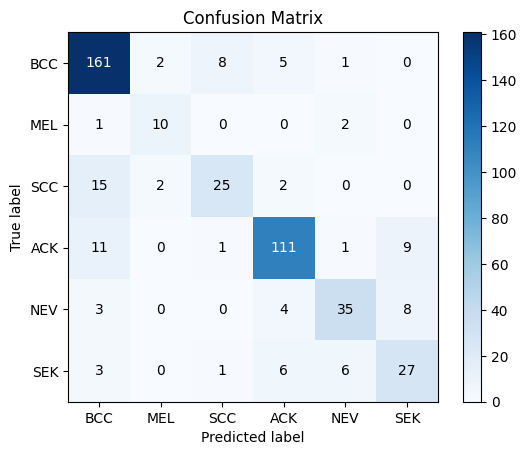

In [65]:
#Confusion matrix
class_order = ['BCC','MEL','SCC','ACK','NEV','SEK']
plot_confusion_matrix(y1_test, y1_pred, normalize=False,labels=class_order)

In [ ]:




ratio = float(np.sum(y1 == 0)) / np.sum(y1 == 1)

xgb = XGBClassifier()
xgb.fit(x1,y1)
y1_pred = xgb.predict(x1_test)

xgb.score(x1_test,y1_test)

